# Kernel Ridge Regression

Load Data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

np.random.seed(0)  

x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

x_plot = np.load('x_plot.npy')
y_plot = np.load('y_plot.npy')


Let's see how the data looks like

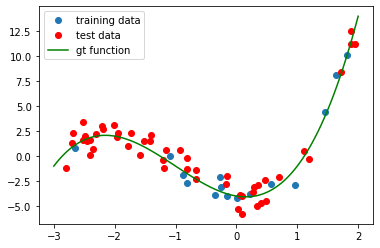

In [2]:
data_fig = plt.figure()
plt.plot(x_train, y_train, 'o')
plt.plot(x_test, y_test, 'or')
plt.plot(x_plot, y_plot, 'g')
plt.legend(['training data', 'test data', 'gt function'])
plt.show()

## Gaussian Kernels: Playground
Since Gaussian Kernels are the most used kernels, we will concentrate on Gaussian Kernels in this notebook. Remember the definition of a Gaussian Kernel:\
\begin{align*}
    k(\boldsymbol{x}, \boldsymbol{x'}) = e^{\left(-\frac{||\boldsymbol{x}-\boldsymbol{x'}||^2}{2\sigma^2}\right)},
\end{align*}
with $ \sigma $ being the bandwidth parameter. Note that the function returns a scalar. \
Let's see how we would code a such a kernel.

In [3]:
def gaussian_kernel(x: np.ndarray, x_prime: np.ndarray, sigma: float) -> np.ndarray:
    """
    :param x: input parameter (shape: [N, d])
    :param x_prime: input parameter (shape: [1, d])
    :param sigma: bandwidht parameter 
    :return : returns the Gaussian kernel (shape: [N, 1])
    """
    diff = x - x_prime
    diff_norm = np.linalg.norm(diff, axis=1)  # we have to take the square, as linalg.norm takes the L2-norm
    return np.exp(-(diff_norm)**2/(2*sigma**2))


Let's look how it look's like for different $ \sigma$ values and a fixed value of $ \boldsymbol{x}' $.

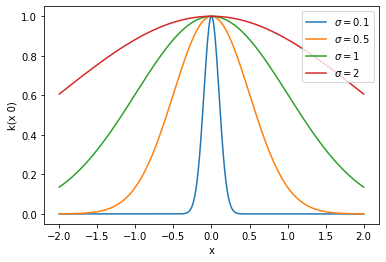

In [5]:
x = np.array(np.linspace(-2, 2, 500)).reshape(-1,1)
x_prime = 0
sigmas = [0.1, 0.5, 1, 2]
kernel_fig = plt.figure()
for sigma in sigmas:
    k_sigma = gaussian_kernel(x, x_prime, sigma)
    plt.plot(x, k_sigma, label='$\sigma = $' + str(sigma))      
plt.ylabel("k(x " +str(x_prime) +')')
plt.xlabel("x")
plt.legend(loc=1)
plt.show()

But how about our data? How would we apply it to our training data? 

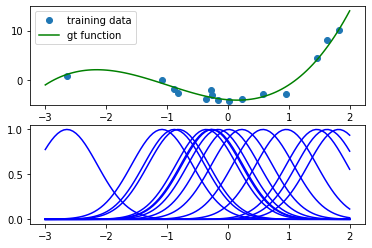

In [6]:
kernels = []
sigma = 0.5
for x_prime in x_train:
    kernels.append(gaussian_kernel(x_plot, x_prime, sigma))


kernel_data_plot = plt.figure()

plt.subplot(2,1,1)
plt.plot(x_train, y_train, 'o')
plt.plot(x_plot, y_plot, 'g')
plt.legend(['training data', 'gt function'])


plt.subplot(2,1,2)
for kernel in kernels:
    plt.plot(x_plot, kernel, 'b')
plt.show()

In this plot we can see that in each training data point (in contrast to linear regression with RBF features), a Gaussian Kernel is centered. Using these kernels the prediction is performed for each input (see next part).

## Kernel Ridge Regression with Gaussian Kernels

Let's go ahead and do regression using Gaussian kernels. Remember the regression equation:

\begin{align*}
    f(\boldsymbol{x}) = \boldsymbol{k}(\boldsymbol{x})^T(\boldsymbol{K} + \lambda \boldsymbol{I})^{-1}\boldsymbol{y},
\end{align*}
where $ \boldsymbol{k}(\boldsymbol{x}) $ is the kernel vector, $ \boldsymbol{K}_{ij} = k(\boldsymbol{x_i, x_j}) $ is the Kernel matrix and $ \boldsymbol{y} $ are the target values from the training data. 

Let's first get the kernel vector:

In [7]:
def get_kernel_vec(X: np.ndarray, x_prime: np.ndarray, sigma: float) -> np.ndarray:
    """
    :param X: training data matrix (shape: [N_train, d])
    :param x_prime: input to kernel vector (shape: [N_inputs x d])
    :param sigma: bandwidth of the kernel 
    :return: return kernel vector evaluated at each point of x_prime (shape: [N_train x N_inputs])
    """
    diff = X[:, None, :] - x_prime[None, :, :]
    return np.exp(-0.5 * np.sum(diff**2, axis=2) / (sigma**2))
    

The Kernel matrix is nothing but applying the kernel vector for the training data set:

In [8]:
def get_kernel_mat(X: np.ndarray, sigma: float) -> np.ndarray:
    """
    :param X: training data matrix (N_train, d)
    :sigma: bandwidth of the kernel(scalar)
    :return: the kernel matrix (N_train x N_train)
    """
    return get_kernel_vec(X, X, sigma)

Let's now implement the prediction function. We use a ridge value $ \lambda = 1e^{-3}$

In [9]:
def predict(x: np.ndarray, x_train: np.ndarray, y_train: np.ndarray, sigma: float) -> np.ndarray:
    """
    :param x: input vector for which we want to get predictions (N_inputs x d)
    :param x_train: training data (N_train x d)
    :param sigma: bandwidth of the kernel
    :return: predicted values according to input x (N_inputs x d)
    """
    K = get_kernel_mat(x_train, sigma)
    k_x = get_kernel_vec(x_train, x, sigma)
    inv_mat_train_output = np.linalg.solve(K + 1e-3 * np.eye(K.shape[0]), y_train)
    return np.dot(k_x.T, inv_mat_train_output)

We will use the mean squared error to measure the training and test error for different $ \sigma $ values:

In [10]:
def mse(y_target: np.ndarray, y_pred: np.ndarray) -> float:
    """
    :param y_target: true y values
    :param y_pred: predicted y values 
    :return: MSE
    """
    return np.sum((y_target-y_pred)**2)/y_pred.shape[0]

Let's thest for different $ \sigma $ values:

minimum test error for sigma = 3


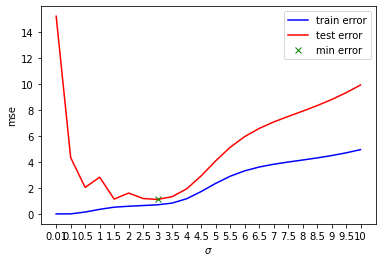

In [11]:
sigmas = [0.01, .1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]

train_errors = []
test_errors = []

for sigma in sigmas:
    c_predict_train = predict(x_train, x_train, y_train, sigma)
    c_predict_test = predict(x_test, x_train, y_train, sigma)
    train_errors.append(mse(y_train, c_predict_train))
    test_errors.append(mse(y_test, c_predict_test))
    
# plot the errors
x_axis = [str(x) for x in sigmas]
min_test_error_index = test_errors.index(min(test_errors))
print('minimum test error for sigma =', x_axis[min_test_error_index])
error_plot = plt.figure()
plt.plot(x_axis, train_errors, 'b')
plt.plot(x_axis, test_errors, 'r')
plt.plot(x_axis[min_test_error_index], test_errors[min_test_error_index], 'gx')
plt.xlabel( "$\sigma$")
plt.ylabel( "mse" )
plt.legend(['train error', 'test error','min error'])

In this plot the typical behavior for the test and the training error can be seen. We have a clear overfitting behavior for small $ \sigma $ values. As the training error vanishes while the test error increases. For high $ \sigma $ values we can see high training and test errors. Indicating an underfitting behavior. \
The best performing model is marked with a green 'x', as the minimum test error is for $ \sigma = 3 $.

Let's look at predictions for different $ \sigma $ values.

for sigma = 3
mse test: 1.1149897316926833
mse train: 0.7024915355840975
mse ground truth: 0.12427609943966363


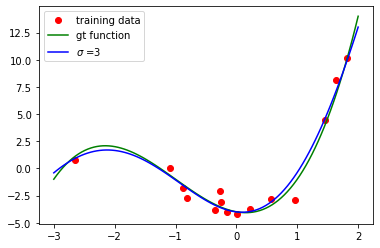

for sigma = 0.1
mse test: 4.337299687199955
mse train: 0.0033027109746655357
mse ground truth: 4.281500893896281


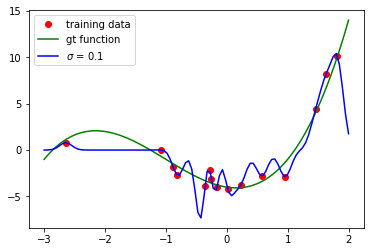

In [12]:
# plot specific sigma predictions:
sigma_plot = 3

y_pred_test = predict(x_test, x_train, y_train, sigma_plot)
y_pred_train = predict(x_train, x_train, y_train, sigma_plot)
y_pred_plot = predict(x_plot, x_train, y_train, sigma_plot)

print('for sigma =', str(sigma_plot))
print('mse test:', mse(y_test, y_pred_test))
print('mse train:', mse(y_train, y_pred_train))
print('mse ground truth:', mse(y_plot, y_pred_plot))

sigma_fig = plt.figure()
plt.plot(x_train, y_train, 'ro')
plt.plot(x_plot, y_plot, 'g')
plt.plot(x_plot, y_pred_plot, 'b')
plt.legend(['training data', 'gt function', '$\sigma$ =' + str(sigma_plot)])
plt.show()



sigma_plot_2 = 0.1

y_pred_test_2 = predict(x_test, x_train, y_train, sigma_plot_2)
y_pred_train_2 = predict(x_train, x_train, y_train, sigma_plot_2)
y_pred_plot_2 = predict(x_plot, x_train, y_train, sigma_plot_2)

print('for sigma =', str(sigma_plot_2))
print('mse test:', mse(y_test, y_pred_test_2))
print('mse train:', mse(y_train, y_pred_train_2))
print('mse ground truth:', mse(y_plot, y_pred_plot_2))

sigma_fig = plt.figure()
plt.plot(x_train, y_train, 'ro')
plt.plot(x_plot, y_plot, 'g')
plt.plot(x_plot, y_pred_plot_2, 'b')
plt.legend(['training data', 'gt function', '$\sigma$ = ' + str(sigma_plot_2)])
plt.show()

For $ \sigma = 3 $ we have the minimum test error. The prediction for this bandwidth can be seen in the above plot.
For $ \sigma = 0.1 $ we have the typical overfitting behavior. For the input region [-2.5, -1.5] there are no training points and since we also have a small bandwidth value $ \sigma $, there is a zero valued prediction. 
